In [1]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init  
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import argparse

ilbe_data = pd.read_csv('ilbe_Crawling.csv')
ilbe_data.shape

(401233, 2)

In [2]:
#train데이터와 test데이터를 나눠주는 함수
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
#70%를 train_set, 15%를 val_set, 15%를 test_data로 둠.
train_set, test_set = split_train_test(ilbe_data, 0.3)
val_set = test_set[:int(len(test_set)/2)]
test_set = test_set[int(len(test_set)/2):]
type(train_set), type(val_set), type(test_set)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [4]:
train_set = train_set.values
val_set = val_set.values
test_set = test_set.values

train_set = train_set.tolist()
val_set = val_set.tolist()
test_set = test_set.tolist()
type(train_set), type(val_set), type(test_set)

(list, list, list)

# 자모단위 분해 함수

In [5]:
# 초성 리스트. 00 ~ 18 총 19개
CHOSUNG_LIST = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
# 중성 리스트. 00 ~ 20 총 21개
JUNGSUNG_LIST = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
# 종성 리스트. 00 ~ 27 + 1(1개 없음) 총 28개
JONGSUNG_LIST = ['J없음', 'Jㄱ', 'Jㄲ', 'Jㄳ', 'Jㄴ', 'Jㄵ', 'Jㄶ', 'Jㄷ', 'Jㄹ', 'Jㄺ', 'Jㄻ', 'Jㄼ', 'Jㄽ', 'Jㄾ', 'Jㄿ', 'Jㅀ', 'Jㅁ', 'Jㅂ', 'Jㅄ', 'Jㅅ', 'Jㅆ', 'Jㅇ', 'Jㅈ', 'Jㅊ', 'Jㅋ', 'Jㅌ', 'Jㅍ', 'Jㅎ']
#숫자 리스트 00 ~ 09 총 10개
NUMBER_LIST = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#알파벳 00 ~ 25 총 25개
ALPHABET_LIST = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
#특수문자 00 ~ 18 총 19개
SPECIAL_CHAR_LIST = ['!', '\"', '#', '$', '%', '&', '\'', '?', '@', '*', '+', ',', '-', '.', '/', '~', ' ', ':', '^']
#추가 총 4개
SINGLE_CHAR_LIST = ['ㄳ', 'ㄵ', 'ㅄ','ㄺ']
#총 127개

ALL_CHAR = []
ALL_CHAR = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
ALL_CHAR += JUNGSUNG_LIST
ALL_CHAR += JONGSUNG_LIST
ALL_CHAR += NUMBER_LIST
ALL_CHAR += ALPHABET_LIST
ALL_CHAR += SPECIAL_CHAR_LIST
ALL_CHAR += SINGLE_CHAR_LIST

In [6]:
#문자열 데이터가 들어오면 one hot encoding을해서 리스트를 반환.
def onehotencoding(string):
    return_list = []
    tmp_list = []
    check = 0
    for i in range(len(string)):
        for k in range(len(ALL_CHAR)):
            if(ALL_CHAR[k] == string[i]):
                tmp_list.append(1)
                check = 1
            else:
                tmp_list.append(0)
        if(check == 1):
            return_list.append(tmp_list)
            tmp_list = []
            check = 0
        else:
            tmp_list = []
    return return_list

In [7]:
#자모단위로 분해
def tokenize(word):
    r_lst = []
    word = str(word)
    for w in list(word.strip()):
        ## 영어인 경우 구분해서 작성함. 
        if '가'<=w<='힣':
            ## 588개 마다 초성이 바뀜. 
            ch1 = (ord(w) - ord('가'))//588
            ## 중성은 총 28가지 종류
            ch2 = ((ord(w) - ord('가')) - (588*ch1)) // 28
            ch3 = (ord(w) - ord('가')) - (588*ch1) - 28*ch2
            r_lst.append(CHOSUNG_LIST[ch1])
            r_lst.append(JUNGSUNG_LIST[ch2])
            if ch3 != 0:
                r_lst.append(JONGSUNG_LIST[ch3])
        elif 'A'<=w<='Z':
            ch = (ord(w) - ord('A'))
            r_lst.append(ALPHABET_LIST[ch])
        elif 'a'<=w<='z':
            ch = (ord(w) - ord('a'))
            r_lst.append(ALPHABET_LIST[ch])
        else:
            r_lst.append(w)
         
    
    return r_lst

In [8]:
#onehotencoding함수와 tokenize함수를 사용해 데이터 배열이 들어오면 자모단위로 분해하고 onehotencoding을 해서 내보냄
def dataprocessing(data_set):
    r_list1 = []
    r_list2 = []
    for i in range(len(data_set)):
        r_list1.append(onehotencoding(tokenize(data_set[i][0])))
        r_list2.append(data_set[i][1])
    return r_list1, r_list2

In [9]:
#train_set, val_set, test_set데이터를 전처리함
train_x_data, train_y_data = dataprocessing(train_set)
val_x_data, val_y_data = dataprocessing(val_set)
test_x_data, test_y_data = dataprocessing(test_set)
train_set = 0
val_set = 0
test_set = 0

In [10]:
len(train_x_data), len(train_x_data[0]), len(train_x_data[0][0])

(280864, 52, 127)

In [11]:
#데이터 크기가 n보다 크면 n까지 자르고, n보다 작으면 n크기까지 zero padding을 함.
def max_resize_data(data):
    n = 200
    for i in range(0, len(data)):
        if(len(data[i]) > n):
            data[i] = data[i][:n]
    return data

def zero_padding_resize_data(data):
    zero_list = [0 for k in range(127)]
    for i in range(0, len(data)):
        for j in range(len(data[i]), 200):
            data[i].append(zero_list)
    return data

In [12]:
#데이터 크기를 일정하게 200크기로 맞춤
train_x_data_resized = zero_padding_resize_data(max_resize_data(train_x_data))
val_x_data_resized = zero_padding_resize_data(max_resize_data(val_x_data))
test_x_data_resized = zero_padding_resize_data(max_resize_data(test_x_data))
train_x_data = 0
val_x_data = 0
test_x_data = 0

In [13]:
#list형태의 자료를 tensor로 바꿈
x_train_torch = torch.FloatTensor(train_x_data_resized)
x_val_torch = torch.FloatTensor(val_x_data_resized)
x_test_torch = torch.FloatTensor(test_x_data_resized)

y_train_torch = torch.FloatTensor(train_y_data)
y_val_torch = torch.FloatTensor(val_y_data)
y_test_torch = torch.FloatTensor(test_y_data)

x_train_torch.shape, x_val_torch.shape, x_test_torch.shape, y_train_torch.shape, y_val_torch.shape, y_test_torch.shape

(torch.Size([280864, 200, 127]),
 torch.Size([60184, 200, 127]),
 torch.Size([60185, 200, 127]),
 torch.Size([280864]),
 torch.Size([60184]),
 torch.Size([60185]))

In [14]:
x_train_torch = x_train_torch.permute(0, 2, 1)
x_val_torch = x_val_torch.permute(0, 2, 1)
x_test_torch = x_test_torch.permute(0, 2, 1)

x_train_torch.shape, x_val_torch.shape, x_test_torch.shape, y_train_torch.shape, y_val_torch.shape, y_test_torch.shape, 

(torch.Size([280864, 127, 200]),
 torch.Size([60184, 127, 200]),
 torch.Size([60185, 127, 200]),
 torch.Size([280864]),
 torch.Size([60184]),
 torch.Size([60185]))

In [15]:
batch_size = 128
learning_rate = 0.0001
num_epoch = 4

In [16]:
x_train_loader = torch.utils.data.DataLoader(x_train_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)
y_train_loader = torch.utils.data.DataLoader(y_train_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)

x_val_loader = torch.utils.data.DataLoader(x_val_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)
y_val_loader = torch.utils.data.DataLoader(y_val_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)

x_test_loader = torch.utils.data.DataLoader(x_test_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)
y_test_loader = torch.utils.data.DataLoader(y_test_torch, batch_size=batch_size
                                            ,shuffle=False, num_workers=0, drop_last =True)

In [19]:
for n, (data) in enumerate(x_train_loader):
    print(n, data.shape)

0 torch.Size([128, 127, 200])
1 torch.Size([128, 127, 200])
2 torch.Size([128, 127, 200])
3 torch.Size([128, 127, 200])
4 torch.Size([128, 127, 200])
5 torch.Size([128, 127, 200])
6 torch.Size([128, 127, 200])
7 torch.Size([128, 127, 200])
8 torch.Size([128, 127, 200])
9 torch.Size([128, 127, 200])
10 torch.Size([128, 127, 200])
11 torch.Size([128, 127, 200])
12 torch.Size([128, 127, 200])
13 torch.Size([128, 127, 200])
14 torch.Size([128, 127, 200])
15 torch.Size([128, 127, 200])
16 torch.Size([128, 127, 200])
17 torch.Size([128, 127, 200])
18 torch.Size([128, 127, 200])
19 torch.Size([128, 127, 200])
20 torch.Size([128, 127, 200])
21 torch.Size([128, 127, 200])
22 torch.Size([128, 127, 200])
23 torch.Size([128, 127, 200])
24 torch.Size([128, 127, 200])
25 torch.Size([128, 127, 200])
26 torch.Size([128, 127, 200])
27 torch.Size([128, 127, 200])
28 torch.Size([128, 127, 200])
29 torch.Size([128, 127, 200])
30 torch.Size([128, 127, 200])
31 torch.Size([128, 127, 200])
32 torch.Size([128

515 torch.Size([128, 127, 200])
516 torch.Size([128, 127, 200])
517 torch.Size([128, 127, 200])
518 torch.Size([128, 127, 200])
519 torch.Size([128, 127, 200])
520 torch.Size([128, 127, 200])
521 torch.Size([128, 127, 200])
522 torch.Size([128, 127, 200])
523 torch.Size([128, 127, 200])
524 torch.Size([128, 127, 200])
525 torch.Size([128, 127, 200])
526 torch.Size([128, 127, 200])
527 torch.Size([128, 127, 200])
528 torch.Size([128, 127, 200])
529 torch.Size([128, 127, 200])
530 torch.Size([128, 127, 200])
531 torch.Size([128, 127, 200])
532 torch.Size([128, 127, 200])
533 torch.Size([128, 127, 200])
534 torch.Size([128, 127, 200])
535 torch.Size([128, 127, 200])
536 torch.Size([128, 127, 200])
537 torch.Size([128, 127, 200])
538 torch.Size([128, 127, 200])
539 torch.Size([128, 127, 200])
540 torch.Size([128, 127, 200])
541 torch.Size([128, 127, 200])
542 torch.Size([128, 127, 200])
543 torch.Size([128, 127, 200])
544 torch.Size([128, 127, 200])
545 torch.Size([128, 127, 200])
546 torc

1026 torch.Size([128, 127, 200])
1027 torch.Size([128, 127, 200])
1028 torch.Size([128, 127, 200])
1029 torch.Size([128, 127, 200])
1030 torch.Size([128, 127, 200])
1031 torch.Size([128, 127, 200])
1032 torch.Size([128, 127, 200])
1033 torch.Size([128, 127, 200])
1034 torch.Size([128, 127, 200])
1035 torch.Size([128, 127, 200])
1036 torch.Size([128, 127, 200])
1037 torch.Size([128, 127, 200])
1038 torch.Size([128, 127, 200])
1039 torch.Size([128, 127, 200])
1040 torch.Size([128, 127, 200])
1041 torch.Size([128, 127, 200])
1042 torch.Size([128, 127, 200])
1043 torch.Size([128, 127, 200])
1044 torch.Size([128, 127, 200])
1045 torch.Size([128, 127, 200])
1046 torch.Size([128, 127, 200])
1047 torch.Size([128, 127, 200])
1048 torch.Size([128, 127, 200])
1049 torch.Size([128, 127, 200])
1050 torch.Size([128, 127, 200])
1051 torch.Size([128, 127, 200])
1052 torch.Size([128, 127, 200])
1053 torch.Size([128, 127, 200])
1054 torch.Size([128, 127, 200])
1055 torch.Size([128, 127, 200])
1056 torch

1522 torch.Size([128, 127, 200])
1523 torch.Size([128, 127, 200])
1524 torch.Size([128, 127, 200])
1525 torch.Size([128, 127, 200])
1526 torch.Size([128, 127, 200])
1527 torch.Size([128, 127, 200])
1528 torch.Size([128, 127, 200])
1529 torch.Size([128, 127, 200])
1530 torch.Size([128, 127, 200])
1531 torch.Size([128, 127, 200])
1532 torch.Size([128, 127, 200])
1533 torch.Size([128, 127, 200])
1534 torch.Size([128, 127, 200])
1535 torch.Size([128, 127, 200])
1536 torch.Size([128, 127, 200])
1537 torch.Size([128, 127, 200])
1538 torch.Size([128, 127, 200])
1539 torch.Size([128, 127, 200])
1540 torch.Size([128, 127, 200])
1541 torch.Size([128, 127, 200])
1542 torch.Size([128, 127, 200])
1543 torch.Size([128, 127, 200])
1544 torch.Size([128, 127, 200])
1545 torch.Size([128, 127, 200])
1546 torch.Size([128, 127, 200])
1547 torch.Size([128, 127, 200])
1548 torch.Size([128, 127, 200])
1549 torch.Size([128, 127, 200])
1550 torch.Size([128, 127, 200])
1551 torch.Size([128, 127, 200])
1552 torch

2018 torch.Size([128, 127, 200])
2019 torch.Size([128, 127, 200])
2020 torch.Size([128, 127, 200])
2021 torch.Size([128, 127, 200])
2022 torch.Size([128, 127, 200])
2023 torch.Size([128, 127, 200])
2024 torch.Size([128, 127, 200])
2025 torch.Size([128, 127, 200])
2026 torch.Size([128, 127, 200])
2027 torch.Size([128, 127, 200])
2028 torch.Size([128, 127, 200])
2029 torch.Size([128, 127, 200])
2030 torch.Size([128, 127, 200])
2031 torch.Size([128, 127, 200])
2032 torch.Size([128, 127, 200])
2033 torch.Size([128, 127, 200])
2034 torch.Size([128, 127, 200])
2035 torch.Size([128, 127, 200])
2036 torch.Size([128, 127, 200])
2037 torch.Size([128, 127, 200])
2038 torch.Size([128, 127, 200])
2039 torch.Size([128, 127, 200])
2040 torch.Size([128, 127, 200])
2041 torch.Size([128, 127, 200])
2042 torch.Size([128, 127, 200])
2043 torch.Size([128, 127, 200])
2044 torch.Size([128, 127, 200])
2045 torch.Size([128, 127, 200])
2046 torch.Size([128, 127, 200])
2047 torch.Size([128, 127, 200])
2048 torch

In [20]:
for n, (labels) in enumerate(y_train_loader):
    print(n, labels.shape)

0 torch.Size([128])
1 torch.Size([128])
2 torch.Size([128])
3 torch.Size([128])
4 torch.Size([128])
5 torch.Size([128])
6 torch.Size([128])
7 torch.Size([128])
8 torch.Size([128])
9 torch.Size([128])
10 torch.Size([128])
11 torch.Size([128])
12 torch.Size([128])
13 torch.Size([128])
14 torch.Size([128])
15 torch.Size([128])
16 torch.Size([128])
17 torch.Size([128])
18 torch.Size([128])
19 torch.Size([128])
20 torch.Size([128])
21 torch.Size([128])
22 torch.Size([128])
23 torch.Size([128])
24 torch.Size([128])
25 torch.Size([128])
26 torch.Size([128])
27 torch.Size([128])
28 torch.Size([128])
29 torch.Size([128])
30 torch.Size([128])
31 torch.Size([128])
32 torch.Size([128])
33 torch.Size([128])
34 torch.Size([128])
35 torch.Size([128])
36 torch.Size([128])
37 torch.Size([128])
38 torch.Size([128])
39 torch.Size([128])
40 torch.Size([128])
41 torch.Size([128])
42 torch.Size([128])
43 torch.Size([128])
44 torch.Size([128])
45 torch.Size([128])
46 torch.Size([128])
47 torch.Size([128])
48

749 torch.Size([128])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1199 torch.Size([128])
1200 torch.Size([128])
1201 torch.Size([128])
1202 torch.Size([128])
1203 torch.Size([128])
1204 torch.Size([128])
1205 torch.Size([128])
1206 torch.Size([128])
1207 torch.Size([128])
1208 torch.Size([128])
1209 torch.Size([128])
1210 torch.Size([128])
1211 torch.Size([128])
1212 torch.Size([128])
1213 torch.Size([128])
1214 torch.Size([128])
1215 torch.Size([128])
1216 torch.Size([128])
1217 torch.Size([128])
1218 torch.Size([128])
1219 torch.Size([128])
1220 torch.Size([128])
1221 torch.Size([128])
1222 torch.Size([128])
1223 torch.Size([128])
1224 torch.Size([128])
1225 torch.Size([128])
1226 torch.Size([128])
1227 torch.Size([128])
1228 torch.Size([128])
1229 torch.Size([128])
1230 torch.Size([128])
1231 torch.Size([128])
1232 torch.Size([128])
1233 torch.Size([128])
1234 torch.Size([128])
1235 torch.Size([128])
1236 torch.Size([128])
1237 torch.Size([128])
1238 torch.Size([128])
1239 torch.Size([128])
1240 torch.Size([128])
1241 torch.Size([128])
1242 torch.

1911 torch.Size([128])
1912 torch.Size([128])
1913 torch.Size([128])
1914 torch.Size([128])
1915 torch.Size([128])
1916 torch.Size([128])
1917 torch.Size([128])
1918 torch.Size([128])
1919 torch.Size([128])
1920 torch.Size([128])
1921 torch.Size([128])
1922 torch.Size([128])
1923 torch.Size([128])
1924 torch.Size([128])
1925 torch.Size([128])
1926 torch.Size([128])
1927 torch.Size([128])
1928 torch.Size([128])
1929 torch.Size([128])
1930 torch.Size([128])
1931 torch.Size([128])
1932 torch.Size([128])
1933 torch.Size([128])
1934 torch.Size([128])
1935 torch.Size([128])
1936 torch.Size([128])
1937 torch.Size([128])
1938 torch.Size([128])
1939 torch.Size([128])
1940 torch.Size([128])
1941 torch.Size([128])
1942 torch.Size([128])
1943 torch.Size([128])
1944 torch.Size([128])
1945 torch.Size([128])
1946 torch.Size([128])
1947 torch.Size([128])
1948 torch.Size([128])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
for n, (data, labels) in enumerate(zip(x_train_loader,y_train_loader)):
    print(n, data.shape, labels.shape)

0 torch.Size([128, 127, 200]) torch.Size([128])
1 torch.Size([128, 127, 200]) torch.Size([128])
2 torch.Size([128, 127, 200]) torch.Size([128])
3 torch.Size([128, 127, 200]) torch.Size([128])
4 torch.Size([128, 127, 200]) torch.Size([128])
5 torch.Size([128, 127, 200]) torch.Size([128])
6 torch.Size([128, 127, 200]) torch.Size([128])
7 torch.Size([128, 127, 200]) torch.Size([128])
8 torch.Size([128, 127, 200]) torch.Size([128])
9 torch.Size([128, 127, 200]) torch.Size([128])
10 torch.Size([128, 127, 200]) torch.Size([128])
11 torch.Size([128, 127, 200]) torch.Size([128])
12 torch.Size([128, 127, 200]) torch.Size([128])
13 torch.Size([128, 127, 200]) torch.Size([128])
14 torch.Size([128, 127, 200]) torch.Size([128])
15 torch.Size([128, 127, 200]) torch.Size([128])
16 torch.Size([128, 127, 200]) torch.Size([128])
17 torch.Size([128, 127, 200]) torch.Size([128])
18 torch.Size([128, 127, 200]) torch.Size([128])
19 torch.Size([128, 127, 200]) torch.Size([128])
20 torch.Size([128, 127, 200])

329 torch.Size([128, 127, 200]) torch.Size([128])
330 torch.Size([128, 127, 200]) torch.Size([128])
331 torch.Size([128, 127, 200]) torch.Size([128])
332 torch.Size([128, 127, 200]) torch.Size([128])
333 torch.Size([128, 127, 200]) torch.Size([128])
334 torch.Size([128, 127, 200]) torch.Size([128])
335 torch.Size([128, 127, 200]) torch.Size([128])
336 torch.Size([128, 127, 200]) torch.Size([128])
337 torch.Size([128, 127, 200]) torch.Size([128])
338 torch.Size([128, 127, 200]) torch.Size([128])
339 torch.Size([128, 127, 200]) torch.Size([128])
340 torch.Size([128, 127, 200]) torch.Size([128])
341 torch.Size([128, 127, 200]) torch.Size([128])
342 torch.Size([128, 127, 200]) torch.Size([128])
343 torch.Size([128, 127, 200]) torch.Size([128])
344 torch.Size([128, 127, 200]) torch.Size([128])
345 torch.Size([128, 127, 200]) torch.Size([128])
346 torch.Size([128, 127, 200]) torch.Size([128])
347 torch.Size([128, 127, 200]) torch.Size([128])
348 torch.Size([128, 127, 200]) torch.Size([128])


655 torch.Size([128, 127, 200]) torch.Size([128])
656 torch.Size([128, 127, 200]) torch.Size([128])
657 torch.Size([128, 127, 200]) torch.Size([128])
658 torch.Size([128, 127, 200]) torch.Size([128])
659 torch.Size([128, 127, 200]) torch.Size([128])
660 torch.Size([128, 127, 200]) torch.Size([128])
661 torch.Size([128, 127, 200]) torch.Size([128])
662 torch.Size([128, 127, 200]) torch.Size([128])
663 torch.Size([128, 127, 200]) torch.Size([128])
664 torch.Size([128, 127, 200]) torch.Size([128])
665 torch.Size([128, 127, 200]) torch.Size([128])
666 torch.Size([128, 127, 200]) torch.Size([128])
667 torch.Size([128, 127, 200]) torch.Size([128])
668 torch.Size([128, 127, 200]) torch.Size([128])
669 torch.Size([128, 127, 200]) torch.Size([128])
670 torch.Size([128, 127, 200]) torch.Size([128])
671 torch.Size([128, 127, 200]) torch.Size([128])
672 torch.Size([128, 127, 200]) torch.Size([128])
673 torch.Size([128, 127, 200]) torch.Size([128])
674 torch.Size([128, 127, 200]) torch.Size([128])


981 torch.Size([128, 127, 200]) torch.Size([128])
982 torch.Size([128, 127, 200]) torch.Size([128])
983 torch.Size([128, 127, 200]) torch.Size([128])
984 torch.Size([128, 127, 200]) torch.Size([128])
985 torch.Size([128, 127, 200]) torch.Size([128])
986 torch.Size([128, 127, 200]) torch.Size([128])
987 torch.Size([128, 127, 200]) torch.Size([128])
988 torch.Size([128, 127, 200]) torch.Size([128])
989 torch.Size([128, 127, 200]) torch.Size([128])
990 torch.Size([128, 127, 200]) torch.Size([128])
991 torch.Size([128, 127, 200]) torch.Size([128])
992 torch.Size([128, 127, 200]) torch.Size([128])
993 torch.Size([128, 127, 200]) torch.Size([128])
994 torch.Size([128, 127, 200]) torch.Size([128])
995 torch.Size([128, 127, 200]) torch.Size([128])
996 torch.Size([128, 127, 200]) torch.Size([128])
997 torch.Size([128, 127, 200]) torch.Size([128])
998 torch.Size([128, 127, 200]) torch.Size([128])
999 torch.Size([128, 127, 200]) torch.Size([128])
1000 torch.Size([128, 127, 200]) torch.Size([128])

1302 torch.Size([128, 127, 200]) torch.Size([128])
1303 torch.Size([128, 127, 200]) torch.Size([128])
1304 torch.Size([128, 127, 200]) torch.Size([128])
1305 torch.Size([128, 127, 200]) torch.Size([128])
1306 torch.Size([128, 127, 200]) torch.Size([128])
1307 torch.Size([128, 127, 200]) torch.Size([128])
1308 torch.Size([128, 127, 200]) torch.Size([128])
1309 torch.Size([128, 127, 200]) torch.Size([128])
1310 torch.Size([128, 127, 200]) torch.Size([128])
1311 torch.Size([128, 127, 200]) torch.Size([128])
1312 torch.Size([128, 127, 200]) torch.Size([128])
1313 torch.Size([128, 127, 200]) torch.Size([128])
1314 torch.Size([128, 127, 200]) torch.Size([128])
1315 torch.Size([128, 127, 200]) torch.Size([128])
1316 torch.Size([128, 127, 200]) torch.Size([128])
1317 torch.Size([128, 127, 200]) torch.Size([128])
1318 torch.Size([128, 127, 200]) torch.Size([128])
1319 torch.Size([128, 127, 200]) torch.Size([128])
1320 torch.Size([128, 127, 200]) torch.Size([128])
1321 torch.Size([128, 127, 200]

1622 torch.Size([128, 127, 200]) torch.Size([128])
1623 torch.Size([128, 127, 200]) torch.Size([128])
1624 torch.Size([128, 127, 200]) torch.Size([128])
1625 torch.Size([128, 127, 200]) torch.Size([128])
1626 torch.Size([128, 127, 200]) torch.Size([128])
1627 torch.Size([128, 127, 200]) torch.Size([128])
1628 torch.Size([128, 127, 200]) torch.Size([128])
1629 torch.Size([128, 127, 200]) torch.Size([128])
1630 torch.Size([128, 127, 200]) torch.Size([128])
1631 torch.Size([128, 127, 200]) torch.Size([128])
1632 torch.Size([128, 127, 200]) torch.Size([128])
1633 torch.Size([128, 127, 200]) torch.Size([128])
1634 torch.Size([128, 127, 200]) torch.Size([128])
1635 torch.Size([128, 127, 200]) torch.Size([128])
1636 torch.Size([128, 127, 200]) torch.Size([128])
1637 torch.Size([128, 127, 200]) torch.Size([128])
1638 torch.Size([128, 127, 200]) torch.Size([128])
1639 torch.Size([128, 127, 200]) torch.Size([128])
1640 torch.Size([128, 127, 200]) torch.Size([128])
1641 torch.Size([128, 127, 200]

1942 torch.Size([128, 127, 200]) torch.Size([128])
1943 torch.Size([128, 127, 200]) torch.Size([128])
1944 torch.Size([128, 127, 200]) torch.Size([128])
1945 torch.Size([128, 127, 200]) torch.Size([128])
1946 torch.Size([128, 127, 200]) torch.Size([128])
1947 torch.Size([128, 127, 200]) torch.Size([128])
1948 torch.Size([128, 127, 200]) torch.Size([128])
1949 torch.Size([128, 127, 200]) torch.Size([128])
1950 torch.Size([128, 127, 200]) torch.Size([128])
1951 torch.Size([128, 127, 200]) torch.Size([128])
1952 torch.Size([128, 127, 200]) torch.Size([128])
1953 torch.Size([128, 127, 200]) torch.Size([128])
1954 torch.Size([128, 127, 200]) torch.Size([128])
1955 torch.Size([128, 127, 200]) torch.Size([128])
1956 torch.Size([128, 127, 200]) torch.Size([128])
1957 torch.Size([128, 127, 200]) torch.Size([128])
1958 torch.Size([128, 127, 200]) torch.Size([128])
1959 torch.Size([128, 127, 200]) torch.Size([128])
1960 torch.Size([128, 127, 200]) torch.Size([128])
1961 torch.Size([128, 127, 200]

In [17]:
class Text_CNN(nn.Module):
    def __init__(self):
        super(Text_CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels = 127, out_channels = 512, kernel_size = 6, stride=1),
            #[batch_size, 512, 195]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
            #[batch_size, 512, 193]
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 512, kernel_size = 9, stride=1),
            #[batch_size, 512, 185]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
            #[batch_size, 512, 183]
        ) 
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 512, kernel_size = 12, stride=1),
            #[batch_size, 512, 172]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
            #[batch_size, 512, 170]
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512*170, out_features=1024),
            #[batch_size, 86016] -> [batch_size, 1024]
            nn.ReLU(),
            nn.Dropout(p = 0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1024),
            #[batch_size, 1024] -> [batch_size, 1024]
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fc3 = nn.Linear(in_features=1024, out_features=1)
        #[batch_size, 1024] -> [batch_size, 2]
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        #[batch_size, 512, 120]
        x = self.conv2(x)
        #[batch_size, 512, 110]
        x = self.conv3(x)
        #[batch_size, 512, 97]
        
        # collapse
        x = x.view(x.size(0), -1) #[batch_size, 49664]
        # linear layer
        x = self.fc1(x) #[batch_size, 1024]
        # linear layer
        x = self.fc2(x) #[batch_size, 1024]
        # linear layer
        x = self.fc3(x) #[batch_size, 2]
        # output layer
        x = self.sigmoid(x)
        
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu 사용
#device = torch.device("cpu")
model = Text_CNN().to(device) #모델을 gpu에 올림
loss_func = nn.BCELoss() #lossfunction 정의
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #optimizer 정의

In [19]:
print(model) #모델 구조 확인

Text_CNN(
  (conv1): Sequential(
    (0): Conv1d(127, 512, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(512, 512, kernel_size=(9,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(512, 512, kernel_size=(12,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=87040, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [20]:
#evaluation function
def eval(x_loader,y_loader, model_name):
    correct = 0
    total = 0

    with torch.no_grad():
        for j, (data, label) in enumerate(zip(x_loader,y_loader)):
            x = data.to(device)
            y_ = label.to(device)

            output = model_name.forward(x)

            for i in range(0, len(output)):
                if(output[i] > 0.5):
                    output[i] = 1
                else:
                    output[i] = 0

            output = output.view(len(output))

            total += label.size(0)
            correct += (output == y_).sum().float()
    return 100*correct/total

In [21]:
loss_arr = [[0 for i in range(len(x_train_loader))] for j in range(num_epoch)]
train_acc = []
val_acc = []
for i in range(num_epoch):
    start = time.time() #시간 측정
    for j, (data, label) in enumerate(zip(x_train_loader,y_train_loader)):
        
        x = data.to(device) #data를 gpu에 올림
        y_ = label.to(device) #label을 gpu에 올림
        
        optimizer.zero_grad() #optimizer 초기화
        output = model.forward(x) #모델 foward 진행
        loss = loss_func(output, y_) #loss function을 사용해서 loss 측정.
        loss.backward() #가중치에 대한 Loss의 변화량을 측정함.
        optimizer.step() #loss가 감소하는 방향으로 가중치를 업데이트
        #loss_arr[i].append(loss.cpu().detach().numpy())
        loss_arr[i][j] = loss.item()
        
        if j == len(x_train_loader)-1: #하나의 epoch를 보면 아래를 실행.
            print("Epoch :", i+1, " Loss :", sum(loss_arr[i], 0.0)/len(loss_arr[i])) #평균 loss 출력
            
            train_acc.append(eval(x_train_loader,y_train_loader, model))
            print("Accuracy of Train Data : {}".format(train_acc[i]))
            
            val_acc.append(eval(x_val_loader,y_val_loader, model))
            print("Accuracy of Validation Data : {}".format(val_acc[i]))
            loss_arr.append(loss.cpu().detach().numpy())
            
    print("running time :", time.time() - start)
    print('---------------------------------------------------------')

    #learning rate decay
    lr = learning_rate * (0.1 ** (i // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    print(param_group['lr'])

C:\Users\green\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch : 1  Loss : 0.2556516927486131
Accuracy of Train Data : 93.81694030761719
Accuracy of Validation Data : 93.38430786132812
running time : 502.29761481285095
---------------------------------------------------------
0.0001
Epoch : 2  Loss : 0.17854092875792693
Accuracy of Train Data : 94.58857727050781
Accuracy of Validation Data : 93.77991485595703
running time : 539.3920135498047
---------------------------------------------------------
0.0001
Epoch : 3  Loss : 0.16429196656558495
Accuracy of Train Data : 95.01232147216797
Accuracy of Validation Data : 93.8331069946289
running time : 616.1363730430603
---------------------------------------------------------
0.0001
Epoch : 4  Loss : 0.15223835073173753
Accuracy of Train Data : 95.32817077636719
Accuracy of Validation Data : 93.80817413330078
running time : 649.0068092346191
---------------------------------------------------------
0.0001


In [24]:
#f1_score function
def f1_score(x_loader, y_loader, model_name):

    with torch.no_grad():
        for j, (data, label) in enumerate(zip(x_loader,y_loader)):
            x = data.to(device)
            y_ = label.to(device)

            output = model_name.forward(x)

            for i in range(0, len(output)):
                if(output[i] >= 0.5):
                    output[i] = 1
                else:
                    output[i] = 0
                    
            #y_true[j] = output
            if j == 0:
                y_true = y_
                y_pred = output
            else:
                y_true = torch.cat([y_true, y_])
                y_pred = torch.cat([y_pred, output])
            
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        y_true = y_true.tolist()
        y_pred = y_pred.tolist()
        
        target_names = ['class 0', 'class 1']
        print(classification_report(y_true, y_pred, target_names=target_names))

In [25]:
#validation set에 대한 precision, recall, f1-score
f1_score(x_val_loader, y_val_loader, model)

              precision    recall  f1-score   support

     class 0       0.96      0.93      0.94     32673
     class 1       0.92      0.95      0.93     27487

    accuracy                           0.94     60160
   macro avg       0.94      0.94      0.94     60160
weighted avg       0.94      0.94      0.94     60160



In [26]:
#하나의 epoch당 평균 loss를 구하기
avg_loss_arr = []
for i in range(num_epoch):
    avg_loss_arr.append(sum(loss_arr[i], 0.0)/len(loss_arr[i]))

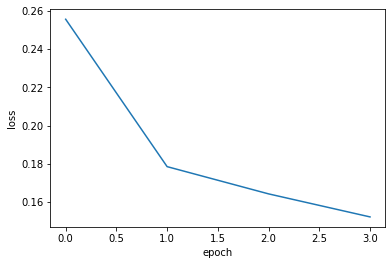

In [31]:
import matplotlib.pyplot as plt

plt.plot(avg_loss_arr)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

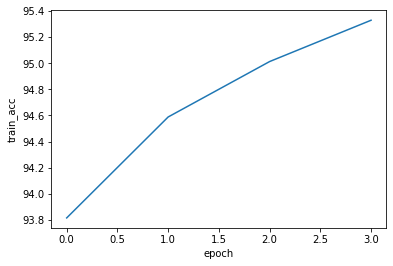

In [28]:
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('train_acc')
plt.show()

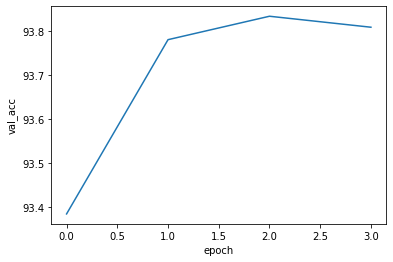

In [29]:
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('val_acc')
plt.show()

In [30]:
#Test Data에 대한 Accuracy
print("Accuracy of Test Data : {}".format(eval(x_test_loader,y_test_loader, model)))

Accuracy of Test Data : 93.78656768798828


In [32]:
#모델 저장
torch.save(model.state_dict(), './text_cnn_pytorch_V4.pth')

In [32]:
#모델 불러오기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_model = Text_CNN().to(device)
load_model.load_state_dict(torch.load('./text_cnn_pytorch_V2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
print("Accuracy of Test Data : {}".format(eval(x_test_loader,y_test_loader, load_model)))

Accuracy of Test Data : 94.19049072265625
